In [33]:
import tensorflow as tf
from tensorflow.keras.datasets import boston_housing
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.utils import shuffle
np.random.seed(0)
import missingno as mg
import datetime
from pmdarima.arima import auto_arima
from datetime import datetime,timedelta

In [34]:
def mape(y, y_pred):
    return np.mean(np.abs((y_pred - y) / y)) * 100

In [35]:
df = pd.read_csv('Google_Stock_Price_Train.csv')
df.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [36]:
test = pd.read_csv('Google_Stock_Price_Test.csv')

In [37]:
cols = [i for i in df.columns if i != 'Date']
min_max_scaler = []
for col in cols:
    df[col] = df[col].apply(lambda x:str(x).replace(',',''))
    df[col]=df[col].astype(float)
    
    test[col] = test[col].apply(lambda x:str(x).replace(',',''))
    test[col]=test[col].astype(float)
    
    scaler_df = pd.DataFrame(df[col])
    mms = MinMaxScaler()
    mms.fit(scaler_df)
    df[col] = mms.transform(scaler_df)
    test[col] = mms.transform(pd.DataFrame(test[col]))
    min_max_scaler.append(mms)

In [38]:
data = df[cols].values
X=[]
y=[]
m=20
for i in range(len(df)-m):
    X.append(data[i:m+i,:])
    y.append(data[m+i,:])
test_last = test.iloc[:m,-5:]
test_x = test.iloc[:m,-5:].values
test_x = test_x.reshape(1,test_x.shape[0],test_x.shape[1])

In [39]:
ind = shuffle(list(range(len(X))))
train_ind = ind[:int(0.8*len(ind))]
vali_ind = ind[int(0.8*len(ind)):]
x_train,y_train = np.array([X[i] for i in train_ind]),np.array([y[i] for i in train_ind])
x_valid,y_valid = np.array([X[i] for i in vali_ind]),np.array([y[i] for i in vali_ind])

In [40]:
def lstm_predict(x_train,y_train,x_valid,y_valid):
    # reshape before input
    model = tf.keras.Sequential()
    # Adding the first LSTM layer and some Dropout regularisation
    # set units = 64 for input layer
    model.add(tf.keras.layers.LSTM(units=64,return_sequences=True,input_shape=(x_train.shape[1],x_train.shape[2])))
    # drop_out layer，to prevent overfit
    model.add(tf.keras.layers.Dropout(0.2))
    # # Adding a second LSTM layer and some Dropout regularisation
    model.add(tf.keras.layers.LSTM(units=64,return_sequences=True,activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(units=64,return_sequences=True,activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(units=40, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    # # Adding a third LSTM layer and some Dropout regularisation
#     model.add(tf.keras.layers.LSTM(units=32,activation='relu'))
#     model.add(tf.keras.layers.Dropout(0.3))
    # Adding the output layer
    # last input layer，input units=1
    model.add(tf.keras.layers.Dense(units=64,activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(units=64,activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(units=y_train.shape[1],activation='linear'))
    # Compiling the RNN, choose adam optimizer 
    adam = tf.keras.optimizers.Adam(lr=0.01)
    model.compile(optimizer=adam, loss='mean_squared_error')#tf.keras.optimizers.Adam(learning_rate=0.001)
    # Fitting the RNN to the Training set
    history = model.fit(x_train, y_train, epochs=500, batch_size=64,verbose=2,validation_data=(x_valid,y_valid))
#     model.save('model.h5')
    print(model.summary())
    import matplotlib.pyplot as plt
#     #Iterative images
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#     epochs_range = range(epoch)
#     plt.plot(epochs_range, loss, label='Train Loss')
#     plt.plot(epochs_range, val_loss, label='Test Loss')
#     plt.legend(loc='upper right')
#     plt.title('Train and Val Loss')
#     plt.show()
    # train loss and validation loss plot
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('LSTM model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()
    return model

C:\Users\admin\miniconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/500
16/16 - 5s - loss: 25.8742 - val_loss: 0.1350
Epoch 2/500
16/16 - 0s - loss: 0.0907 - val_loss: 0.0376
Epoch 3/500
16/16 - 0s - loss: 0.0507 - val_loss: 0.0269
Epoch 4/500
16/16 - 0s - loss: 0.0411 - val_loss: 0.0270
Epoch 5/500
16/16 - 0s - loss: 0.0313 - val_loss: 0.0143
Epoch 6/500
16/16 - 0s - loss: 0.0270 - val_loss: 0.0127
Epoch 7/500
16/16 - 0s - loss: 0.0246 - val_loss: 0.0176
Epoch 8/500
16/16 - 0s - loss: 0.0245 - val_loss: 0.0122
Epoch 9/500
16/16 - 0s - loss: 0.0234 - val_loss: 0.0133
Epoch 10/500
16/16 - 0s - loss: 0.0227 - val_loss: 0.0153
Epoch 11/500
16/16 - 0s - loss: 0.0220 - val_loss: 0.0142
Epoch 12/500
16/16 - 0s - loss: 0.0213 - val_loss: 0.0118
Epoch 13/500
16/16 - 0s - loss: 0.0213 - val_loss: 0.0114
Epoch 14/500
16/16 - 0s - loss: 0.0211 - val_loss: 0.0099
Epoch 15/500
16/16 - 0s - loss: 0.0207 - val_loss: 0.0133
Epoch 16/500
16/16 - 0s - loss: 0.0200 - val_loss: 0.0114
Epoch 17/500
16/16 - 0s - loss: 0.0192 - val_loss: 0.0113
Epoch 18/500
16/16 - 0

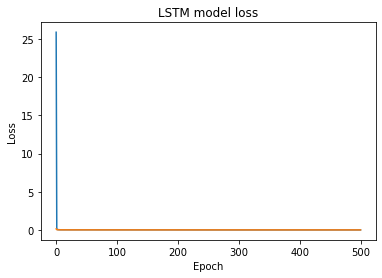

In [41]:
model = lstm_predict(x_train,y_train,x_valid,y_valid)

In [42]:
n = 10
input_x = test_x
result = []
for i in range(n):
    y_pre = model.predict(input_x)
    result.append(y_pre)
    y_pre = y_pre.reshape(y_pre.shape[0],1,y_pre.shape[1])
    input_x = np.hstack((test_x,y_pre))[:,1:,:]

In [43]:
res = pd.DataFrame(columns=cols)
for i in range(len(result)):
    for j in range(len(cols)):
        res.loc[i,cols[j]] = result[i][0][j]

In [44]:
# print('lstm mape:',mape(y_valid, lstm_pre))

In [45]:
for i in range(len(cols)):
    mms = min_max_scaler[i]
    res[cols[i]] = mms.inverse_transform(res[cols[i]].values.reshape(-1, 1))
    test_last[cols[i]] = mms.inverse_transform(test_last[cols[i]].values.reshape(-1, 1))

In [46]:
test_last = pd.concat([test_last,res[:1]])
test_last = test_last.reset_index(drop=True)
res.index = list(range(m,m+len(res)))
res

,Open,High,Low,Close,Volume
20,743.471596,753.385433,738.016263,749.627438,1.584559e+06
21,726.304565,733.800767,719.867150,734.077435,1.670828e+06
22,720.923940,727.684513,714.323825,729.285493,1.701548e+06
23,719.151652,725.662570,712.494427,727.707570,1.711769e+06
24,718.579046,725.012112,711.898483,727.206681,1.715128e+06
25,718.394490,724.802357,711.706128,727.045182,1.716212e+06
26,718.334605,724.734375,711.643793,726.992870,1.716564e+06
27,718.315252,724.712289,711.623560,726.975894,1.716678e+06
28,718.308908,724.705139,711.616984,726.970379,1.716715e+06
29,718.306857,724.702809,711.614844,726.968585,1.716727e+06


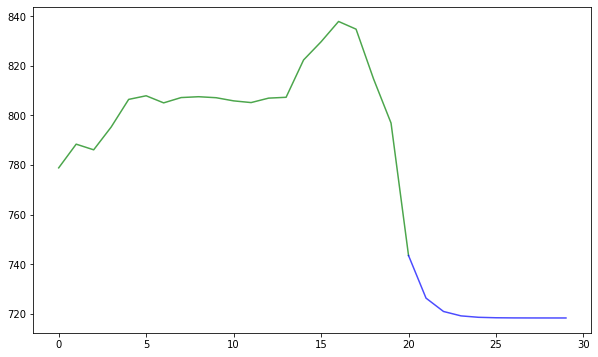

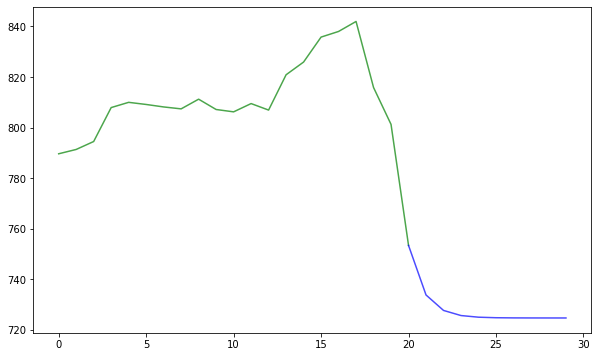

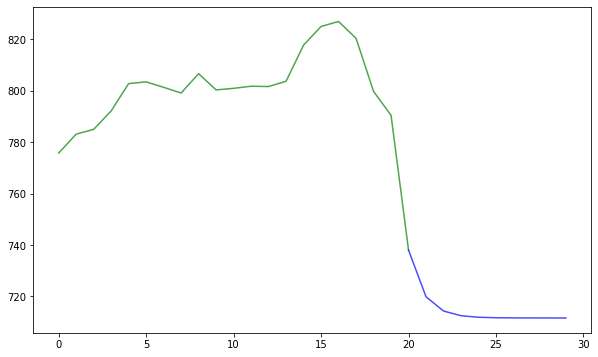

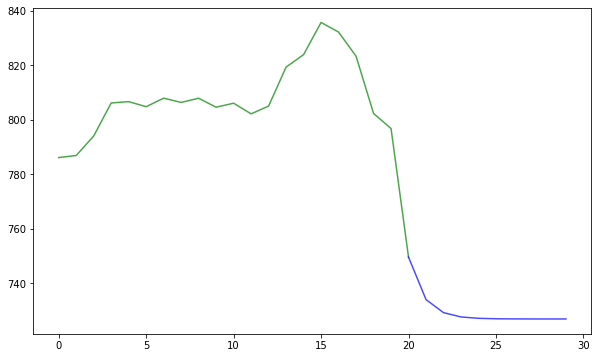

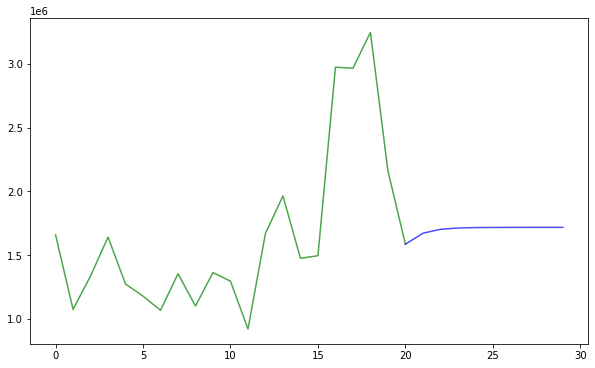

In [47]:
for col in cols:
    plt.figure(figsize=(10,6))
    plt.plot(test_last.index,test_last[col],'g',alpha=0.7)
    plt.plot(res.index,res[col],'b',alpha=0.7)
    plt.show()